## Import Module

In [1]:
# Data Wrangling
import pandas as pd
from pandas import Series
import numpy as np
!pip install klib
!pip install optuna
!pip install bayesian-optimization
!pip install catboost
!pip install -q -U keras-tuner

# Visualization
import matplotlib.pylab as plt
from matplotlib import font_manager, rc
import seaborn as sns
plt.rc('font', family='AppleGothic')
%matplotlib inline
plt.rcParams['axes.unicode_minus'] = False 


# EDA
import klib


# Preprocessing & Feature Engineering
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.feature_selection import SelectPercentile
from sklearn.decomposition import PCA
from gensim.models import word2vec
import kerastuner as kt

# Hyperparameter Optimization
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from bayes_opt import BayesianOptimization


# Modeling
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.base import ClassifierMixin
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import BaggingClassifier
import optuna


# Evaluation
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss


# Utility
import os
import time
import random
import warnings; warnings.filterwarnings("ignore")
from IPython.display import Image
import pickle
from tqdm import tqdm, tqdm_notebook
import platform
from itertools import combinations
from scipy.stats.mstats import gmean
!pip install shap
import tensorflow as tf
from tensorflow import keras
import joblib
print(tf.__version__)
import gc

  Using cached optuna-2.10.0-py3-none-any.whl (308 kB)
  Using cached cmaes-0.8.2-py3-none-any.whl (15 kB)
  Using cached autopage-0.4.0-py3-none-any.whl (20 kB)
  Using cached pyperclip-1.8.2.tar.gz (20 kB)
  Using cached pyreadline3-3.3-py3-none-any.whl (95 kB)
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11112 sha256=b054c077f2639833f4b473b0ca3e770564acbe3ef7f3e3547a1a23450c712683
  Stored in directory: c:\users\user\appdata\local\pip\cache\wheels\7f\1a\65\84ff8c386bec21fca6d220ea1f5498a0367883a78dd5ba6122
Successfully built pyperclip
  Using cached bayesian-optimization-1.2.0.tar.gz (14 kB)
  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-py3-none-any.whl size=11690 sha256=8fcf5286cbe98008b048af24499e0ed7f563049c03aa0092ff37a63fd8b2c1df
  Stored in directory: c:\users\user\appdata\local\pip\cache\wheels\37\fa\19\f93e793d3944567a60b3ab93b446cf7370cc82c60c1d1c613f
Successfully built bayesian-optimization


ModuleNotFoundError: No module named 'gensim'

### Load Data & Reset Seed

In [2]:
SHAP_THRESHOLD = 0    # feature로 사용할 최소 SHAP feature importance
DATA_REDUCTION = 1.0  # 학습 데이터 축소 비율
TRAIN_RATIO = 0.6     # 학습 데이터를 Train과 Validation으로 나누는 비율

In [3]:
# 매번 모델링을 할 때마다 동일한 결과를 얻기 위해 랜덤 시드 설정 동일하게 유지
# 럭키 시드 찾는건 시간상 어려움

def reset_seeds(reset_graph_with_backend=None):
    if reset_graph_with_backend is not None:
        K = reset_graph_with_backend
        K.clear_session()
        tf.compat.v1.reset_default_graph()
        print("KERAS AND TENSORFLOW GRAPHS RESET")  # optional

    np.random.seed(1)
    random.seed(2)
    tf.compat.v1.set_random_seed(3)
    os.environ['CUDA_VISIBLE_DEVICES'] = ''  # for GPU
    print("RANDOM SEEDS RESET")  # optional
   
reset_seeds()

RANDOM SEEDS RESET


In [ ]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [4]:
train = pd.read_csv(os.path.abspath("../input") + '/response_train.csv')
train.sort_values(by='TIME',inplace=True)

panel = pd.read_csv(os.path.abspath("../input") + '/panel.csv')

test = pd.read_csv(os.path.abspath("../input") + '/response_test.csv').sort_values(by='ID')

survey = pd.read_csv(os.path.abspath("../input") + '/survey.csv')

### Data Preprocessing

#### survey 가성비 컬럼 생성

In [5]:
survey['EFC'] = survey['CPI'] / survey['LOI']

#### panel 질문 응답수

In [6]:
panel_Questions = panel.iloc[:,4:]

panel_Questions_count = []
for i in range(panel_Questions.shape[0]):
            panel_Questions_count.append(pd.notna(panel_Questions.iloc[i,:].values).sum())

panel['Questions_count'] = panel_Questions_count

#### panel - 데이터 정제 및 병합

In [7]:
# 성별, 지역 값이 Nan 값인 패널 1명 test에도 존재 하지 않아 그냥 drop
panel.drop(8315, axis=0, inplace=True)

In [8]:
# 겹치는 columms 제거  # sq1,sq2,sq3가 BIRTH, GENDER, REGION 컬럼보다 결측치가 더 많음.

del panel['SQ1']

del panel['SQ2']

del panel['SQ3']

In [9]:
# merge

train=pd.merge(pd.merge(train,panel,on="userID"),survey,on="surveyID")

test=pd.merge(pd.merge(test,panel,on="userID"),survey,on="surveyID")

#### Handling Missing Values

In [10]:
# 결측값 비율이 % 이하인 column만 사용
features = []
for f in train.columns:
    if train[f].isnull().sum()/train.shape[0] > 0.3:
        print(f, '\t', train[f].nunique(), '\t', train[f].isnull().sum()/train.shape[0])
        features.append(f)

B4 	 733 	 0.30726936583927594
B5 	 719 	 0.3123738732575725
C1 	 1819 	 0.3676381080820416
C2 	 84 	 0.47678798962460034
C3 	 1110 	 0.48999233936471576
F1 	 146 	 0.518416415984934
F2 	 83 	 0.5308220777184397
H1 	 865 	 0.5505034058935712
T1 	 91 	 0.557678548161784
X1 	 70 	 0.5767936377373865
X2 	 55 	 0.5855288417718925
X3 	 48 	 0.603304288711951
X4 	 61 	 0.635134564757856
DQ1 	 63 	 0.6571707685491058
DQ2 	 155 	 0.6632203663198752
DQ3 	 147 	 0.6718042743367902
DQ4 	 77 	 0.6739833855766774
DQ5 	 9 	 0.6802054852758593
DQ6 	 11 	 0.6811175433441681
DQ7 	 12 	 0.6852596286559551
CATEGORIES 	 91 	 0.8198596617290198


In [11]:
train.drop(columns = features, inplace = True)
test.drop(columns = features, inplace = True)

#### Encoding SQ4 ~ B3 

In [13]:
def handle_profile(x):
    if x in ['1', '2', '3', '4', '5', '6']:
        return int(x)
    elif x in ['1,', '2,', '3,', '4,', '5,', '6,']:
        return int(x[0])
    else:
        return 99

train.SQ4 = train.SQ4.apply(handle_profile)
test.SQ4 = test.SQ4.apply(handle_profile)

In [14]:
def handle_profile(x):
    if x in ['1', '2', '3', '4']:
        return int(x)
    elif x in ['1.0', '2.0', '3.0', '4.0']:
        return int(x[0])
    else:
        return 99

train.SQ5 = train.SQ5.apply(handle_profile)
test.SQ5 = test.SQ5.apply(handle_profile)

In [15]:
def handle_profile(x):
    if x in ['1', '2']:
        return int(x)
    elif x in ['1,', '2,']:
        return int(x[0])
    else:
        return 99

train.SQ6 = train.SQ6.apply(handle_profile)
test.SQ6 = test.SQ6.apply(handle_profile)

In [16]:
value1 = pd.Series(range(1,17)).apply(lambda x: str(x)).tolist()
value2 = pd.Series(np.arange(1.0,17.0)).apply(lambda x: str(x)).tolist()
def handle_profile(x):
    if x in value1:
        return int(x)
    elif x in value2:
        return int(x[0])
    else:
        return 99

train.SQ7 = train.SQ7.apply(handle_profile)
test.SQ7 = test.SQ7.apply(handle_profile)

In [17]:
def handle_profile(x):
    if x in ['1', '2', '3', '4', '5']:
        return int(x)
    else:
        return 99

train.SQ8 = train.SQ8.apply(handle_profile)
test.SQ8 = test.SQ8.apply(handle_profile)

In [18]:
values = pd.Series(range(1,23)).apply(lambda x: str(x)).tolist()
def handle_profile(x):    
    if x in values:
        return int(x)
    else:
        return 99

train.A1 = train.A1.apply(handle_profile)
test.A1 = test.A1.apply(handle_profile)

In [19]:
def handle_profile(x):    
    if x in ['1']:
        return 2
    elif x in ['2', '3']:
        return 3
    elif x in ['4', '5', '6', '7']:
        return 4
    elif x in ['8']:
        return 5
    else:
        return 99

train.B1 = train.B1.apply(handle_profile)
test.B1 = test.B1.apply(handle_profile)

In [20]:
def handle_profile(x):
    if x in ['1', '2', '3', '4', '5', '6']:
        return int(x)
    else:
        return 99

train.B2 = train.B2.apply(handle_profile)
test.B2 = test.B2.apply(handle_profile)

In [21]:
def handle_profile(x):    
    if x in ['1', '2', '3']:
        return int(x)
    elif x in ['1,', '2,', '3,']:
        return int(x[0])
    elif x in ['99', '99,']:
        return 99
    else:
        return 4  # 기타 제조사

train.B3 = train.B3.apply(handle_profile)
test.B3 = test.B3.apply(handle_profile)

In [22]:
train['TIME'] = train['TIME'].astype("datetime64")
test['TIME'] = test['TIME'].astype("datetime64")
before_train = train.query("TIME <= '2021-01-01 00:00:00'")
train = train.query("TIME>='2021-01-01 00:00:00'")

In [23]:
def null_x(x):
    global train; global test;
    for filln in x:
        train = train.merge(train.groupby(['BIRTH','GENDER','TYPE','Questions_count','SQ5','SQ6'])[filln].agg([('exp', np.mean)]).reset_index(), on=['BIRTH','GENDER','TYPE','Questions_count','SQ5','SQ6'], how='left')
        train[filln] = np.where(train[filln].isna(), train['exp'], train[filln])
        train.drop(labels="exp",axis=1, inplace=True)
        train[filln] = train[filln].fillna(0)

        test = test.merge(test.groupby(['BIRTH','GENDER','TYPE','Questions_count','SQ5','SQ6'])[filln].agg([('exp', np.mean)]).reset_index(), on=['BIRTH','GENDER','TYPE','Questions_count','SQ5','SQ6'], how='left')
        test[filln] = np.where(test[filln].isna(), test['exp'], test[filln])
        test.drop(labels="exp",axis=1, inplace=True)
        test[filln] = test[filln].fillna(0)

#### Variable of Times

In [24]:
data = [train,test]
for i in data:
    i['DAY'] = i['TIME'].dt.day
    i['WEEKDAY'] = i['TIME'].dt.dayofweek
    i['HOUR'] = i['TIME'].dt.hour
    i['HOUR_range'] = pd.cut(i['HOUR'], 4, labels = ['새벽', '오전', '오후', '야간'], right = True, include_lowest=True)

#### panel ID별 누적 평균 포인트

In [25]:
Points_earned_b = pd.DataFrame(before_train.query('STATUS==1').groupby('userID')['CPI'].agg([('Points_earned',np.sum)])).reset_index()
Points_earned = pd.DataFrame(train.query('STATUS==1').groupby('userID')['CPI'].agg([('Points_earned',np.sum)])).reset_index()
train = train.merge(Points_earned_b, how='left')

test = test.merge(Points_earned_b, how='left')


In [26]:
Points_earned_mean = pd.DataFrame(before_train.query('STATUS==1').groupby('userID')['CPI'].agg([('Points_earned_mean',np.mean)])).reset_index()
Points_earned_mean1 = pd.DataFrame(train.query('STATUS==1').groupby('userID')['CPI'].agg([('Points_earned_mean',np.mean)])).reset_index()
train = train.merge(Points_earned_mean, how='left')

test = test.merge(Points_earned_mean, how='left')


In [27]:
null_x(["Points_earned",'Points_earned_mean'])

In [28]:
train['CPI_mean'] = train['Points_earned_mean'] < train['CPI']
train['CPI_mean'] = train['CPI_mean'].apply(lambda x : 1 if x==True else 0)


test['CPI_mean'] = test['Points_earned_mean'] < test['CPI']
test['CPI_mean'] = test['CPI_mean'].apply(lambda x : 1 if x==True else 0)


#### panel ID별 누적 평균 난이도

In [29]:
IR_mean_b = pd.DataFrame(before_train.query('STATUS==1').groupby('userID')['IR'].agg([('Difficulty_earned_mean',np.mean)])).reset_index()

IR_mean = pd.DataFrame(train.query('STATUS==1').groupby('userID')['IR'].agg([('Difficulty_earned__mean',np.mean)])).reset_index()


train = train.merge(IR_mean_b, how='left')

test = test.merge(IR_mean_b, how='left')

In [30]:
IR_sum_b = pd.DataFrame(before_train.query('STATUS==1').groupby('userID')['IR'].agg([('Difficulty_earned_sum',np.sum)])).reset_index()

IR_sum = pd.DataFrame(train.query('STATUS==1').groupby('userID')['IR'].agg([('Difficulty_earned_sum',np.sum)])).reset_index()


train = train.merge(IR_sum_b, how='left')

test = test.merge(IR_sum_b, how='left')

In [31]:
null_x(["Difficulty_earned_sum",'Difficulty_earned_mean'])

In [32]:
train['IR_eff'] = train['Difficulty_earned_mean'] > train['IR']
train['IR_eff'] = train['IR_eff'].apply(lambda x : 1 if x==True else 0)


test['IR_eff'] = test['Difficulty_earned_mean'] > test['IR']
test['IR_eff'] = test['IR_eff'].apply(lambda x : 1 if x==True else 0)


#### panel ID별 누적 평균 시간

In [33]:
Time_earned_b = pd.DataFrame(before_train.query('STATUS==1').groupby('userID')['LOI'].agg([('Time_earned',np.sum)])).reset_index()
Time_earned = pd.DataFrame(train.query('STATUS==1').groupby('userID')['LOI'].agg([('Time_earned',np.sum)])).reset_index()
train = train.merge(Time_earned_b, how='left')
test = test.merge(Time_earned_b, how='left')

In [34]:
Time_earned_mean = pd.DataFrame(before_train.query('STATUS==1').groupby('userID')['LOI'].agg([('Time_earned_mean',np.mean)])).reset_index()
Time_earned_mean1 = pd.DataFrame(train.query('STATUS==1').groupby('userID')['LOI'].agg([('Time_earned_mean',np.mean)])).reset_index()
train = train.merge(Time_earned_mean, how='left')

test = test.merge(Time_earned_mean, how='left')


In [35]:
null_x(["Time_earned",'Time_earned_mean'])

In [36]:
train['LOI_eff_mean'] = train['Time_earned_mean'] > train['LOI']
train['LOI_eff_mean'] = train['LOI_eff_mean'].apply(lambda x : 1 if x==True else 0)


test['LOI_eff_mean'] = test['Time_earned_mean'] > test['LOI']
test['LOI_eff_mean'] = test['LOI_eff_mean'].apply(lambda x : 1 if x==True else 0)


#### panel ID별 누적 평균 가성비

In [37]:
Time_earned_b = pd.DataFrame(before_train.query('STATUS==1').groupby('userID')['EFC'].agg([('EFC_earned',np.sum)])).reset_index()
Time_earned = pd.DataFrame(train.query('STATUS==1').groupby('userID')['EFC'].agg([('EFC_earned',np.sum)])).reset_index()
train = train.merge(Time_earned_b, how='left')

test = test.merge(Time_earned_b, how='left')


In [38]:
Time_earned_mean = pd.DataFrame(before_train.query('STATUS==1').groupby('userID')['EFC'].agg([('EFC_earned_mean',np.mean)])).reset_index()
Time_earned_mean1 = pd.DataFrame(train.query('STATUS==1').groupby('userID')['EFC'].agg([('EFC_earned_mean',np.mean)])).reset_index()
train = train.merge(Time_earned_mean, how='left')

test = test.merge(Time_earned_mean, how='left')


In [39]:
null_x(["EFC_earned",'EFC_earned_mean'])

In [40]:
train['CPI_eff_mean'] = train['EFC_earned_mean'] < train['EFC']
train['CPI_eff_mean'] = train['CPI_eff_mean'].apply(lambda x : 1 if x==True else 0)


test['CPI_eff_mean'] = test['EFC_earned_mean'] < test['EFC']
test['CPI_eff_mean'] = test['CPI_eff_mean'].apply(lambda x : 1 if x==True else 0)


#### panel ID별 리워드, 난이도, 시간, 가성비 최대 최소 비교

In [41]:
# CPI MIN
user_CPI_min = before_train.groupby('userID')['CPI'].agg([('user_CPI_min', np.min)]).reset_index()

train = train.merge(user_CPI_min[['userID','user_CPI_min']], on = 'userID', how= 'left')

test = test.merge(user_CPI_min[['userID','user_CPI_min']], on = 'userID', how= 'left')

In [42]:
null_x(["user_CPI_min"])

In [43]:
train['CPI_min'] = train['user_CPI_min'] < train['CPI']
train['CPI_min'] = train['CPI_min'].apply(lambda x : 1 if x==True else 0)
train.drop(labels="user_CPI_min",axis=1,inplace=True)

test['CPI_min'] = test['user_CPI_min'] < test['CPI']
test['CPI_min'] = test['CPI_min'].apply(lambda x : 1 if x==True else 0)
test.drop(labels="user_CPI_min",axis=1,inplace=True)

In [44]:
# IR MAX
user_IR_max = before_train.groupby('userID')['IR'].agg([('user_IR_max', np.max)]).reset_index()

train = train.merge(user_IR_max[['userID','user_IR_max']], on = 'userID', how= 'left')


test = test.merge(user_IR_max[['userID','user_IR_max']], on = 'userID', how= 'left')


In [45]:
null_x(["user_IR_max"])

In [46]:
train['IR_max'] = train['user_IR_max'] > train['IR']
train['IR_max'] = train['IR_max'].apply(lambda x : 1 if x==True else 0)
train.drop(labels="user_IR_max",axis=1,inplace=True)

test['IR_max'] = test['user_IR_max'] > test['IR']
test['IR_max'] = test['IR_max'].apply(lambda x : 1 if x==True else 0)
test.drop(labels="user_IR_max",axis=1,inplace=True)

In [47]:
# LOI MAX
user_LOI_max = before_train.groupby('userID')['LOI'].agg([('user_LOI_max', np.max)]).reset_index()

train = train.merge(user_LOI_max[['userID','user_LOI_max']], on = 'userID', how= 'left')


test = test.merge(user_LOI_max[['userID','user_LOI_max']], on = 'userID', how= 'left')


In [48]:
null_x(["user_LOI_max"])

In [49]:
train['LOI_max'] = train['user_LOI_max'] > train['LOI']
train['LOI_max'] = train['LOI_max'].apply(lambda x : 1 if x==True else 0)
train.drop(labels="user_LOI_max",axis=1,inplace=True)

test['LOI_max'] = test['user_LOI_max'] > test['LOI']
test['LOI_max'] = test['LOI_max'].apply(lambda x : 1 if x==True else 0)
test.drop(labels="user_LOI_max",axis=1,inplace=True)

In [50]:
# EFC MIN
user_EFC_min = before_train.groupby('userID')['EFC'].agg([('user_EFC_min', np.min)]).reset_index()

train = train.merge(user_EFC_min[['userID','user_EFC_min']], on = 'userID', how= 'left')


test = test.merge(user_EFC_min[['userID','user_EFC_min']], on = 'userID', how= 'left')


In [51]:
null_x(["user_EFC_min"])

In [52]:
train['EFC_min'] = train['user_EFC_min'] < train['EFC']
train['EFC_min'] = train['EFC_min'].apply(lambda x : 1 if x==True else 0)
train.drop(labels="user_EFC_min",axis=1,inplace=True)

test['EFC_min'] = test['user_EFC_min'] < test['EFC']
test['EFC_min'] = test['EFC_min'].apply(lambda x : 1 if x==True else 0)
test.drop(labels="user_EFC_min",axis=1,inplace=True)

#### 응답율 

In [53]:
### 응답율

res_freq = train.query('STATUS == 1').groupby('userID')['userID'].agg([('FREQ',np.size)]).reset_index()
send_freq = train.groupby('userID')['userID'].agg([('SEND',np.size)]).reset_index()
train = train.merge(res_freq,how="left").merge(send_freq,how="left")
train['RESRATE'] = train['FREQ'] / train['SEND']
del  train['SEND'],train['FREQ']

test = test.merge(res_freq,how="left").merge(send_freq,how="left")
test['RESRATE'] = test['FREQ'] / test['SEND']
del  test['SEND'],test['FREQ']

train['RESRATE']
test['RESRATE']
#null_x(["RESRATE"])

0          0.783951
1          0.094444
2          0.338384
3          0.895238
4          0.009217
             ...   
1355512    0.130719
1355513         NaN
1355514    0.461538
1355515    0.461538
1355516    0.461538
Name: RESRATE, Length: 1355517, dtype: float64

#### 성별별 난이도 평균

In [54]:
res_freq = before_train.query('STATUS == 1').groupby('GENDER')['IR'].agg([('g_i','mean')]).reset_index()
train = pd.merge(train, res_freq, how='left')

test = pd.merge(test, res_freq, how='left')

#### Title

In [55]:
import re

word_counts = {}
def count_word(x): # 응답한 서베이 제목에서 한글 단어만 분리하고 빈도 계산
    if x['STATUS'] == 1:
        for w in re.sub(r'[^ ㄱ-ㅣ가-힣]', '', x['TITLE']).split():
            word_counts[w] = word_counts.get(w, 0) + 1
def score_word(x): # 빈도의 합으로 제목을 Encoding
    score = 0
    for w in re.sub(r'[^ ㄱ-ㅣ가-힣]', '', x['TITLE']).split():
        score += word_counts.get(w, 0)
    return score    
            
train.apply(count_word, axis=1)
train.TITLE = train.apply(score_word, axis=1)
test.TITLE = test.apply(score_word, axis=1)

In [56]:
y_train = train['STATUS']
train.drop('STATUS', axis=1, inplace=True)

test_id = test.iloc[:,0:1]
test.drop('ID', axis=1, inplace=True)

In [57]:
#성능 개선에 무의미한 Feature 제거
train.drop(['userID', 'surveyID', 'TIME'], axis=1, inplace=True)
test.drop(['userID', 'surveyID', 'TIME'], axis=1, inplace=True)

####  Handling Missing Values

#### <나머지는 범주형은 새로운 값으로 대치하고 결측값이 있는 수치형은 0으로 변환>

In [58]:
cat_list=['BIRTH', 'GENDER', 'REGION','TYPE', 'SQ4', 'SQ5', 'SQ6', 'SQ7', 'SQ8', 'A1', 'B1', 'B2', 'B3','HOUR_range']

In [59]:
num_list=list(set(train.columns)-set(cat_list))

In [60]:
train[cat_list]=train[cat_list].astype("category")
test[cat_list]=test[cat_list].astype("category")

In [61]:
for i in cat_list:
    train[i] =train[i].cat.add_categories('unknown')
    test[i] =test[i].cat.add_categories('unknown')
    train[i].fillna("unknown",inplace=True)
    test[i].fillna("unknown",inplace=True)

for i in num_list:
    train[i].fillna(0,inplace=True)
    test[i].fillna(0,inplace=True)

#### Data Scaling

In [62]:
#StandardScaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train[num_list] = scaler.fit_transform(train[num_list])
test[num_list] = scaler.transform(test[num_list])

#### One-hot Encoding

In [63]:
# 원핫 인코딩
df_encoded = pd.get_dummies(pd.concat([train, test]), columns=cat_list)
X_train = df_encoded[:train.shape[0]]
X_test = df_encoded[train.shape[0]:]

### Feature Selection

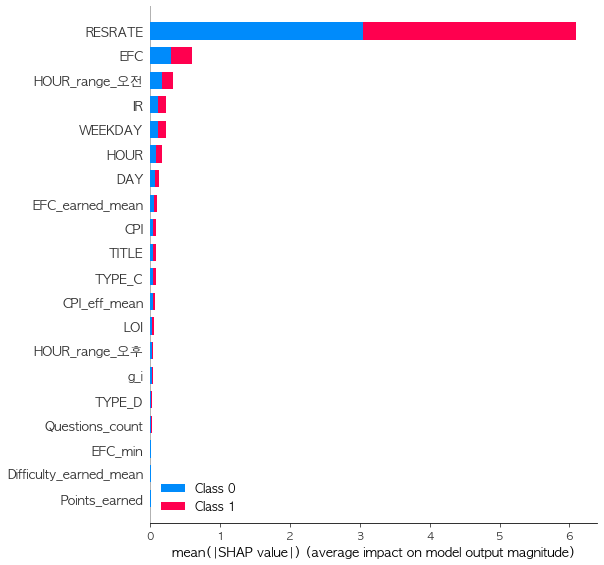

,column_name,shap_importance
25,RESRATE,3.044693
5,EFC,0.30016
217,HOUR_range_오전,0.164079
2,IR,0.110958
7,WEEKDAY,0.109274
...,...,...
90,BIRTH_1997.0,0.0
91,BIRTH_1998.0,0.0
92,BIRTH_1999.0,0.0
93,BIRTH_2000.0,0.0


In [64]:
# Method: Using SHAP values 
import shap
from lightgbm import LGBMClassifier

# DF, based on which importance is checked
X_importance = X_train

# Explain model predictions using shap library:
model = LGBMClassifier(random_state=0).fit(X_train, y_train)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_importance)

# Plot summary_plot as barplot:
shap.summary_plot(shap_values, X_importance, plot_type='bar')

shap_sum = np.abs(shap_values).mean(axis=1)[1,:]
importance_df = pd.DataFrame([X_importance.columns.tolist(), shap_sum.tolist()]).T
importance_df.columns = ['column_name', 'shap_importance']
importance_df = importance_df.sort_values('shap_importance', ascending=False)
importance_df

In [65]:
# feature 중요도가 0 이상
SHAP_THRESHOLD = 0
features_selected = importance_df.query('shap_importance > @SHAP_THRESHOLD').column_name.tolist()
train = X_train[features_selected]
test =X_test[features_selected]
print(train.shape)

(1979651, 50)


In [ ]:
train.to_csv('train_data.csv', index = False)
test.to_csv('test_data.csv', index = False)